# Deep Dreams (with Caffe)

Dreaming with different *.caffemodels and other Image tools

## Using Different Models
Many different .caffemodels have been created. Dreaming with the different models gives provides amazingly different effects. Below will guide you as to how different models may be used. Directly below is a list of models that may be used to 'Dream'. 

In [15]:
!ls /home/jack/Desktop/Ubuntu16.04/notebooks/models

8conv3fc_DSN			      models_places
alexnet_places365		      new
bvlc_alexnet			      nin_imagenet
bvlc_googlenet			      nin_imagenet.caffemodel
bvlc_reference_caffenet		      nin_imagnet
bvlc_reference_rcnn_ilsvrc13	      oxford102
cars				      place
CIFAR10_full			      places205CNN
cnn_age_gender_models_and_data.0.0.2  placesCNN_upgraded
finetune_flickr_style		      reset152_places365
google				      resmet10
googlenet			      resnet10
googlenet_places205		      train_iter_2000
googlenet_places365		      vgg16hybrid1365
GoogleNet_SOD			      vgg16_places365
GoogleNet_SOS			      VGG16_SOD
hybridCNN			      vgg19
hybridCNN_upgraded		      VGG_SOD_finetune
illust2vec_ver200


In [3]:
!ls /home/jack/Desktop/Ubuntu16.04/notebooks/models/googlenet_places205

categoryIndex_places205.csv  googlelet_places205_train_iter_2400000.caffemodel
deploy_places205.protxt      readme
deploy.prototxt		     train_val_googlenet_places205.prototxt
deploy.protxt


In [4]:
lines = open("/home/jack/Desktop/Ubuntu16.04/notebooks/models/googlenet_places205/deploy.prototxt").readlines()
for line in lines:
    line = line.replace("\n", "")
    if "top" in line:
        print line

  top: "conv1/7x7_s2"
  top: "conv1/7x7_s2"
  top: "pool1/3x3_s2"
  top: "pool1/norm1"
  top: "conv2/3x3_reduce"
  top: "conv2/3x3_reduce"
  top: "conv2/3x3"
  top: "conv2/3x3"
  top: "conv2/norm2"
  top: "pool2/3x3_s2"
  top: "inception_3a/1x1"
  top: "inception_3a/1x1"
  top: "inception_3a/3x3_reduce"
  top: "inception_3a/3x3_reduce"
  top: "inception_3a/3x3"
  top: "inception_3a/3x3"
  top: "inception_3a/5x5_reduce"
  top: "inception_3a/5x5_reduce"
  top: "inception_3a/5x5"
  top: "inception_3a/5x5"
  top: "inception_3a/pool"
  top: "inception_3a/pool_proj"
  top: "inception_3a/pool_proj"
  top: "inception_3a/output"
  top: "inception_3b/1x1"
  top: "inception_3b/1x1"
  top: "inception_3b/3x3_reduce"
  top: "inception_3b/3x3_reduce"
  top: "inception_3b/3x3"
  top: "inception_3b/3x3"
  top: "inception_3b/5x5_reduce"
  top: "inception_3b/5x5_reduce"
  top: "inception_3b/5x5"
  top: "inception_3b/5x5"
  top: "inception_3b/pool"
  top: "inception_3b/pool_proj"
  top: "inception_3b/pool

In [5]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import caffe

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [6]:
model_path = '/home/jack/Desktop/Ubuntu16.04/notebooks/models/googlenet_places205/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'googlelet_places205_train_iter_2400000.caffemodel'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

##  Producing dreams

Making the "dream" images is very simple. Essentially it is just a gradient ascent process that tries to maximize the L2 norm of activations of a particular DNN layer. Here are a few simple tricks that we found useful for getting good images:
* offset image by a random jitter
* normalize the magnitude of gradient ascent steps
* apply ascent across multiple scales (octaves)

First we implement a basic gradient ascent step function, applying the first two tricks:

In [7]:
# notice the change from inception_4c/output to inception_4c_output
# def make_step(net, step_size=1.5, end='inception_4c/output', jitter=32, clip=True):
def make_step(net, step_size=1.5, end='inception_4c/output', jitter=32, clip=True):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    net.forward(end=end)
    dst.diff[:] = dst.data  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)    

Next we implement an ascent through different scales. We call these scales "octaves".

In [8]:
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, end='inception_4c/output', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in xrange(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

Now we are ready to let the neural network to reveal its dreams! Let's take a [cloud image](https://commons.wikimedia.org/wiki/File:Appearance_of_sky_for_weather_forecast,_Dhaka,_Bangladesh.JPG) as a starting point:

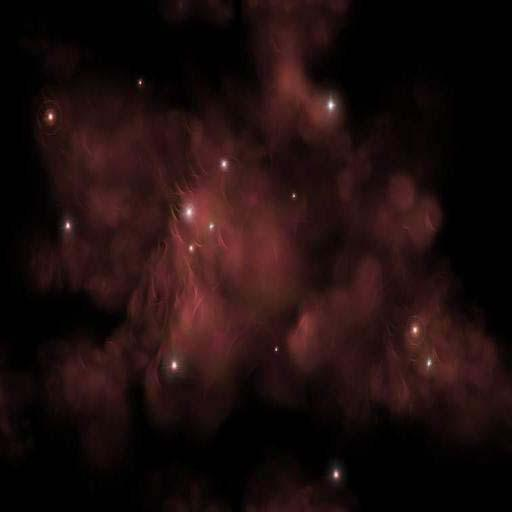

In [9]:
img = np.float32(PIL.Image.open('/home/jack/Downloads/ogre-1.11.2/Samples/Media/materials/textures/spacesky.jpg'))
showarray(img)

Running the next code cell starts the detail generation process. You may see how new patterns start to form, iteration by iteration, octave by octave.

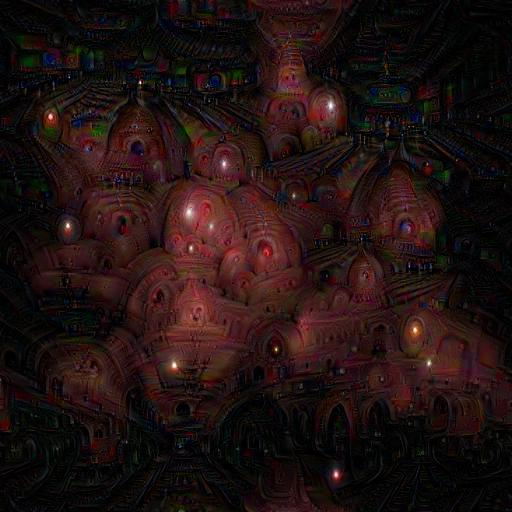

3 9 inception_4c/output (512, 512, 3)


In [10]:
_=deepdream(net, img)

The complexity of the details generated depends on which layer's activations we try to maximize. Higher layers produce complex features, while lower ones enhance edges and textures, giving the image an impressionist feeling:

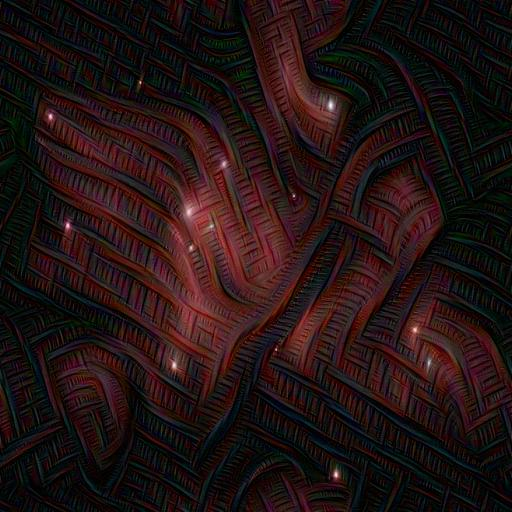

3 9 inception_3b/5x5_reduce (512, 512, 3)


In [11]:
_=deepdream(net, img, end='inception_3b/5x5_reduce')

We encourage readers to experiment with layer selection to see how it affects the results. Execute the next code cell to see the list of different layers. You can modify the `make_step` function to make it follow some different objective, say to select a subset of activations to maximize, or to maximize multiple layers at once. There is a huge design space to explore!

### The script below lightens the image . The 'Dream Effects' are more evident in a lighter image.

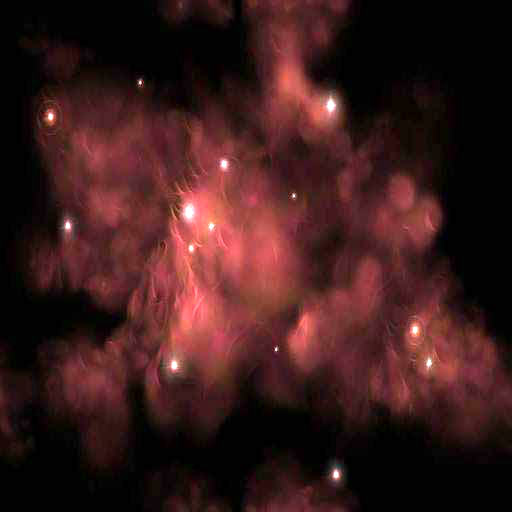

In [14]:
    import PIL.Image
    im1 = PIL.Image.open("/home/jack/Downloads/ogre-1.11.2/Samples/Media/materials/textures/spacesky.jpg")
    im2 = im1.point(lambda p: p * 2)
    im2.save("spacesky-lighter2.jpg")
    im2

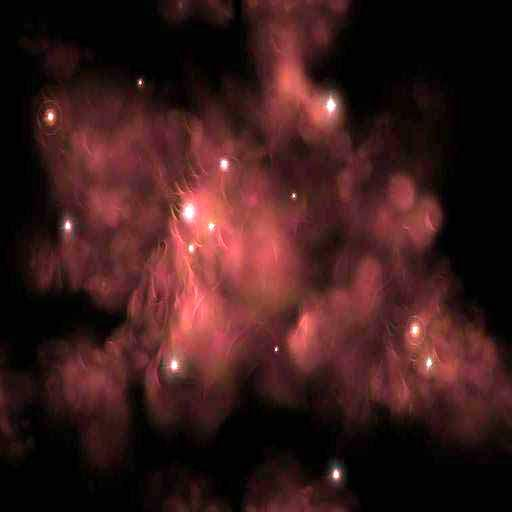

In [16]:
# open as np.float32
img = np.float32(PIL.Image.open('spacesky-lighter2.jpg'))
showarray(img)

In [17]:
net.blobs.keys()

['data',
 'conv1/7x7_s2',
 'pool1/3x3_s2',
 'pool1/norm1',
 'conv2/3x3_reduce',
 'conv2/3x3',
 'conv2/norm2',
 'pool2/3x3_s2',
 'pool2/3x3_s2_pool2/3x3_s2_0_split_0',
 'pool2/3x3_s2_pool2/3x3_s2_0_split_1',
 'pool2/3x3_s2_pool2/3x3_s2_0_split_2',
 'pool2/3x3_s2_pool2/3x3_s2_0_split_3',
 'inception_3a/1x1',
 'inception_3a/3x3_reduce',
 'inception_3a/3x3',
 'inception_3a/5x5_reduce',
 'inception_3a/5x5',
 'inception_3a/pool',
 'inception_3a/pool_proj',
 'inception_3a/output',
 'inception_3a/output_inception_3a/output_0_split_0',
 'inception_3a/output_inception_3a/output_0_split_1',
 'inception_3a/output_inception_3a/output_0_split_2',
 'inception_3a/output_inception_3a/output_0_split_3',
 'inception_3b/1x1',
 'inception_3b/3x3_reduce',
 'inception_3b/3x3',
 'inception_3b/5x5_reduce',
 'inception_3b/5x5',
 'inception_3b/pool',
 'inception_3b/pool_proj',
 'inception_3b/output',
 'pool3/3x3_s2',
 'pool3/3x3_s2_pool3/3x3_s2_0_split_0',
 'pool3/3x3_s2_pool3/3x3_s2_0_split_1',
 'pool3/3x3_s2_p

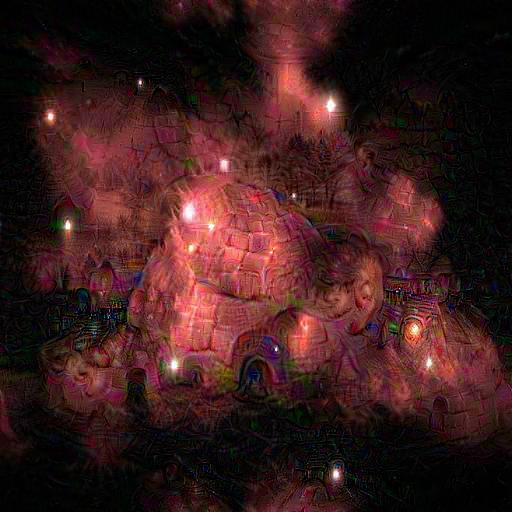

3 9 inception_5b/output (512, 512, 3)


In [18]:
_=deepdream(net, img, end='inception_5b/output')

What if we feed the `deepdream` function its own output, after applying a little zoom to it? It turns out that this leads to an endless stream of impressions of the things that the network saw during training. Some patterns fire more often than others, suggestive of basins of attraction.

We will start the process from the same sky image as above, but after some iteration the original image becomes irrelevant; even random noise can be used as the starting point.

In [21]:
!mkdir frames2
frame = img
frame_i = 0

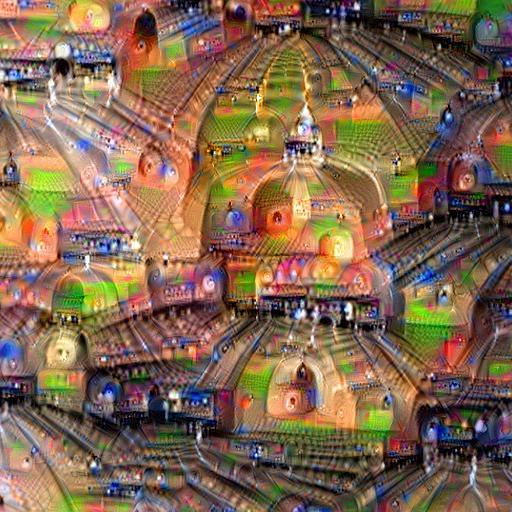

3 9 inception_4c/output (512, 512, 3)


In [22]:
h, w = frame.shape[:2]
s = 0.05 # scale coefficient
for i in xrange(30):
    frame = deepdream(net, frame)
    PIL.Image.fromarray(np.uint8(frame)).save("frames2/%04d.jpg"%frame_i)
    frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    frame_i += 1

Be careful running the code above, it can bring you into very strange realms!

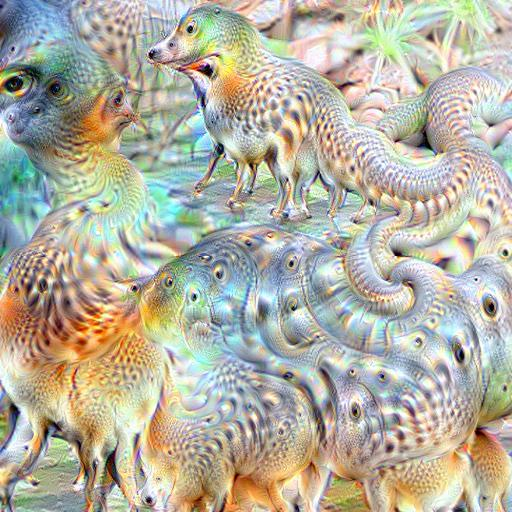

In [23]:
Image(filename='frames/0029.jpg')

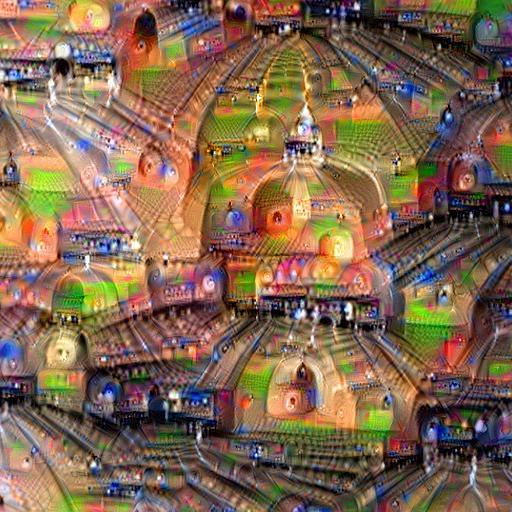

In [24]:
Image(filename='frames2/0029.jpg')

In [ ]:
!ffmpeg -framerate 3 -i frames2/%04d.jpg -c:v libx264 -r 30 -pix_fmt yuv420p frames2/out2.mp4